First install all the requirements from the root directory (`pip install -r requirements.txt --user`), then switch to the demo directory (same as this notebook) and run the install script (`sh script.sh`) from the demo directory to get the models (optimized and non-optimized) and to install the additional libraries for the demo.

In [2]:
!sh script.sh

Reading package lists... Done
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
The directory '/home/gene/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/gene/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |██████████████████████████

Next, import all the methods from the `model.py` file. If you do this but get empty black images when you try generating things later (or if blockparse failed to install for you) then you need to change line 25 (`optimized = True`) in `model.py` to `optimized = False`, reload the kernel, and re-import model.

In [1]:
from model import *

Loaded model
Warm started tf model


Now let's open and display the image. If the image is empty or does not load properly, it may not have found a face. To fix this, crop the image so that the face is most of it (>50%). Ideally the image is bigger than 256px on each side. Note you could also crop and align the face manually and then just load the image without aligning it using:

    img = Image.open('faces/%s'%path1)
    img = img.convert('RGB')  # if image is RGBA or Grayscale etc
    img = img.resize((256,256), Image.BICUBIC)
    img = np.array(img)
    

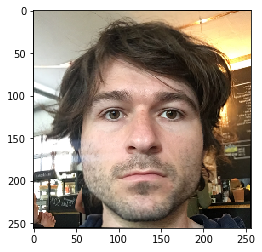

In [2]:
from align_face import *

img = align('gene.png')
pyplot.imshow(img)

Now let's encode the image into its latent vector. It has to be reshaped as a tensor and then use the `encode` function.

In [3]:
img = np.reshape(np.array(img), [1, 256, 256, 3])
z = encode(img)
print("shape of z: ", z.shape)  # i.e. 256x256x3
print("z=", z)

shape of z:  (1, 196608)
z= [[-3.54969311 -2.26060963 -0.48482805 ...,  1.27446973 -1.51126492
   0.62676549]]


Now let's decode z into an image, and then display that image. Notice that it looks exactly the same as the original image. Also note that it returns a tensor of size [1, 256, 256, 3] so we have to pull out the first one at index 0.

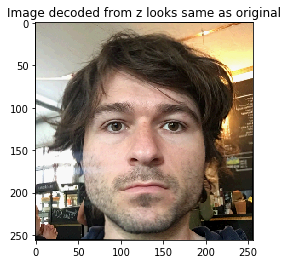

In [4]:
x_new = decode(z)

pyplot.figure()
pyplot.title('Image decoded from z looks same as original')
pyplot.imshow(x_new[0])

Let's make some changes to z. We can add attribute vectors.

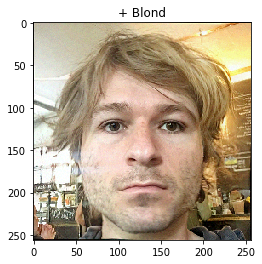

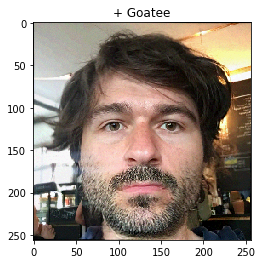

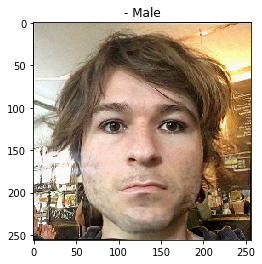

In [5]:
tags = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
tags = tags.split()

# take original z, and 0.9 * the manipulation vector corresponding to blond hair
z_blond = np.copy(z)
z_blond[0] += 0.7 * z_manipulate[tags.index('Blond_Hair')]
x_blond = decode(z_blond)

pyplot.figure()
pyplot.title('+ Blond')
pyplot.imshow(x_blond[0])

# same thing, but goatee
z_goatee = np.copy(z)
z_goatee[0] += 0.7 * z_manipulate[tags.index('Goatee')]
x_goatee = decode(z_goatee)

pyplot.figure()
pyplot.title('+ Goatee')
pyplot.imshow(x_goatee[0])

# same thing but do opposite of male (subtract male)
z_male = np.copy(z)
z_male[0] -= 0.7 * z_manipulate[tags.index('Male')]
x_male = decode(z_male)

pyplot.figure()
pyplot.title('- Male')
pyplot.imshow(x_male[0])


Now let's load two images and try to interpolate between them. First load two faces.

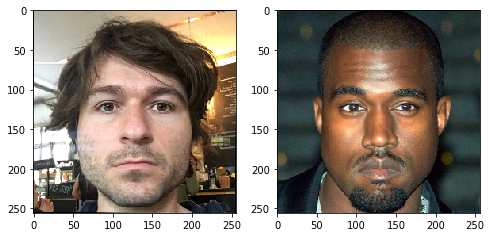

In [8]:
img1 = align('gene.png')
img2 = align('kanye.jpg')
pyplot.figure(figsize=(8,4))
pyplot.subplot(1, 2, 1)
pyplot.imshow(img1)
pyplot.subplot(1, 2, 2)
pyplot.imshow(img2)

Now encode both of them and interpolate frames between their two z-vectors.

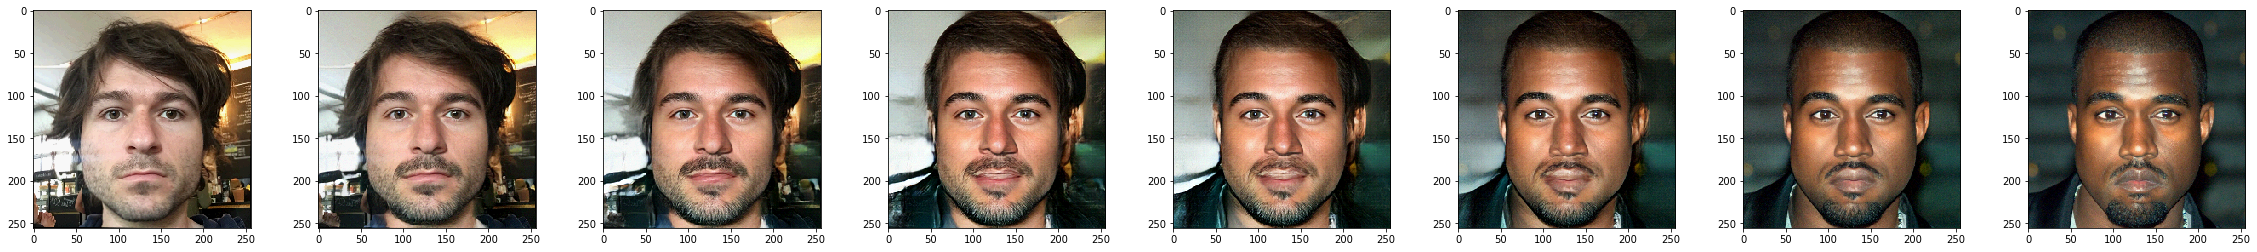

In [108]:
z1 = encode(img1)
z2 = encode(img2)

pyplot.figure(figsize=(40,4))
for i in range(8):
    ratio = float(i) / 7
    z_tween = np.copy(z1)
    z_tween[0] = (1.0-ratio) * z1 + ratio * z2
    img_tween = decode(z_tween)
    pyplot.subplot(1, 8, i+1)
    pyplot.imshow(img_tween[0])

Let's make new faces. To do that, we sample a z-vector from a random normal distribution using `numpy.random.randn`. We multiply the magnitude by a scalar we call the "temperature". A very low temperature gives you very believable but average-looking and repetive faces. A very high temperature gives you more diversity but less realism. Let's try at a few different values.

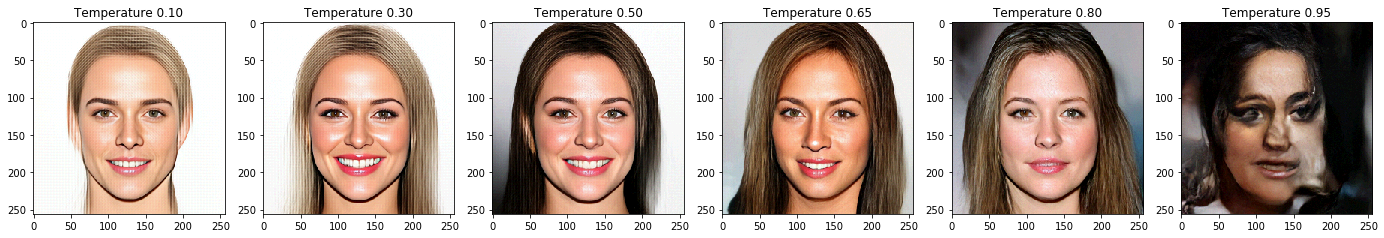

In [99]:
temperatures = [0.1, 0.3, 0.5, 0.65, 0.8, 0.95]
pyplot.figure(figsize=(24, 4))
for t, temperature in enumerate(temperatures):
    z_new = np.array([temperature * np.random.randn(256*256*3)])
    x_new = decode(z_new)
    pyplot.subplot(1, len(temperatures), t+1)
    pyplot.title('Temperature %0.2f' % temperature)
    pyplot.imshow(x_new[0])


## Overwriting larger image

Let's say you want to find a face in a larger image, do some operation on it, then put that back into the original image. The easiest way to do that is by forking the FaceAligner class from imutils and making some changes to it.

In [21]:
from imutils.face_utils.helpers import FACIAL_LANDMARKS_68_IDXS
from imutils.face_utils.helpers import FACIAL_LANDMARKS_5_IDXS
from imutils.face_utils.helpers import shape_to_np
import numpy as np
import cv2


class FaceWarper:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=512, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect, z_addition):
        # convert the landmark (x, y)-coordinates to a NumPy 
        h1, w1 = image.shape[:2]
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        #simple hack ;)
        if (len(shape)==68):
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # invert the previous affine transformation for later 
        Mi = cv2.invertAffineTransform(M)
        
        # BGR -> RGB
        output = output[:,:,::-1]

        # encode with GLOW, do operations on z
        z = encode(output)
        z[0] += z_addition
        
        # decode back to image and back to BGR
        output = decode(z)[0]
        output = output[:,:,::-1]

        # invert the affine transformation on output
        output = cv2.warpAffine(output, Mi, (w1, h1),
            flags=cv2.INTER_CUBIC)

        # overwrite original image with masked output
        mask = np.sum(output, axis=2) == 0.0
        image = np.multiply(mask.reshape((h1, w1, 1)), image)
        image += output

        return image


Now open an imagee and do the following.

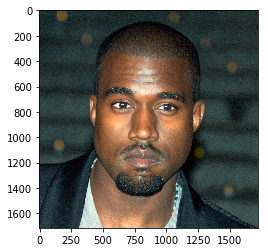

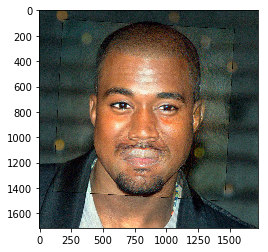

In [22]:
img_path = 'kanye.jpg'

z_addition = 1.75 * z_manipulate[tags.index('Smiling')]

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
warper = FaceWarper(predictor, desiredFaceWidth=256, desiredLeftEye=(0.371, 0.480))


img = Image.open(img_path)
img = np.array(img.convert('RGB'))
#img =   # Convert from RGB to BGR format
#img = imutils.resize(img, width=800)

# detect faces in the grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 2)

if len(rects) > 0:
    img2 = warper.align(img[:, :, ::-1], gray, rects[0], z_addition)[:, :, ::-1]
    img2 = np.array(Image.fromarray(img2).convert('RGB'))
    pyplot.figure(1)
    pyplot.imshow(img)
    pyplot.figure(2)
    pyplot.imshow(img2)
else:
    print('no face found')
    
